## `PyMC3`

`PyMC3` es la librería por defecto de Inferencia Bayesiana.
Implementa (junto a otras librerías como `pyro` y `TensorFlow Probability`) programación probabilística.

> ¿Qué es la programación probabilística?

Es el paradigma de crear modelos probabilísticos a partir de variables y la programación de estas.



## Regresión Lineal

Como ejemplo de funcionamiento, consideremos esta simple Regresión Lineal Bayesiana.

Idea: Predecir $y$ que se encuentran normalmente distribuidos:

$$y \sim \mathcal{N}(\mu, \sigma^2 )$$

$$\mu = \alpha + \beta_1X_1  + \beta_2 X_2$$

En donde 

- $\alpha$ es el intercepto.
- $\beta_i$ el coeficiente del atributo $X_i$ 
- $\sigma$ el error.

Ejecutaremos el ajuste de esta Regresión Lineal usando los siguientes datos generados de forma aleatoria.


In [ ]:
!pip install pymc3

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [ ]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

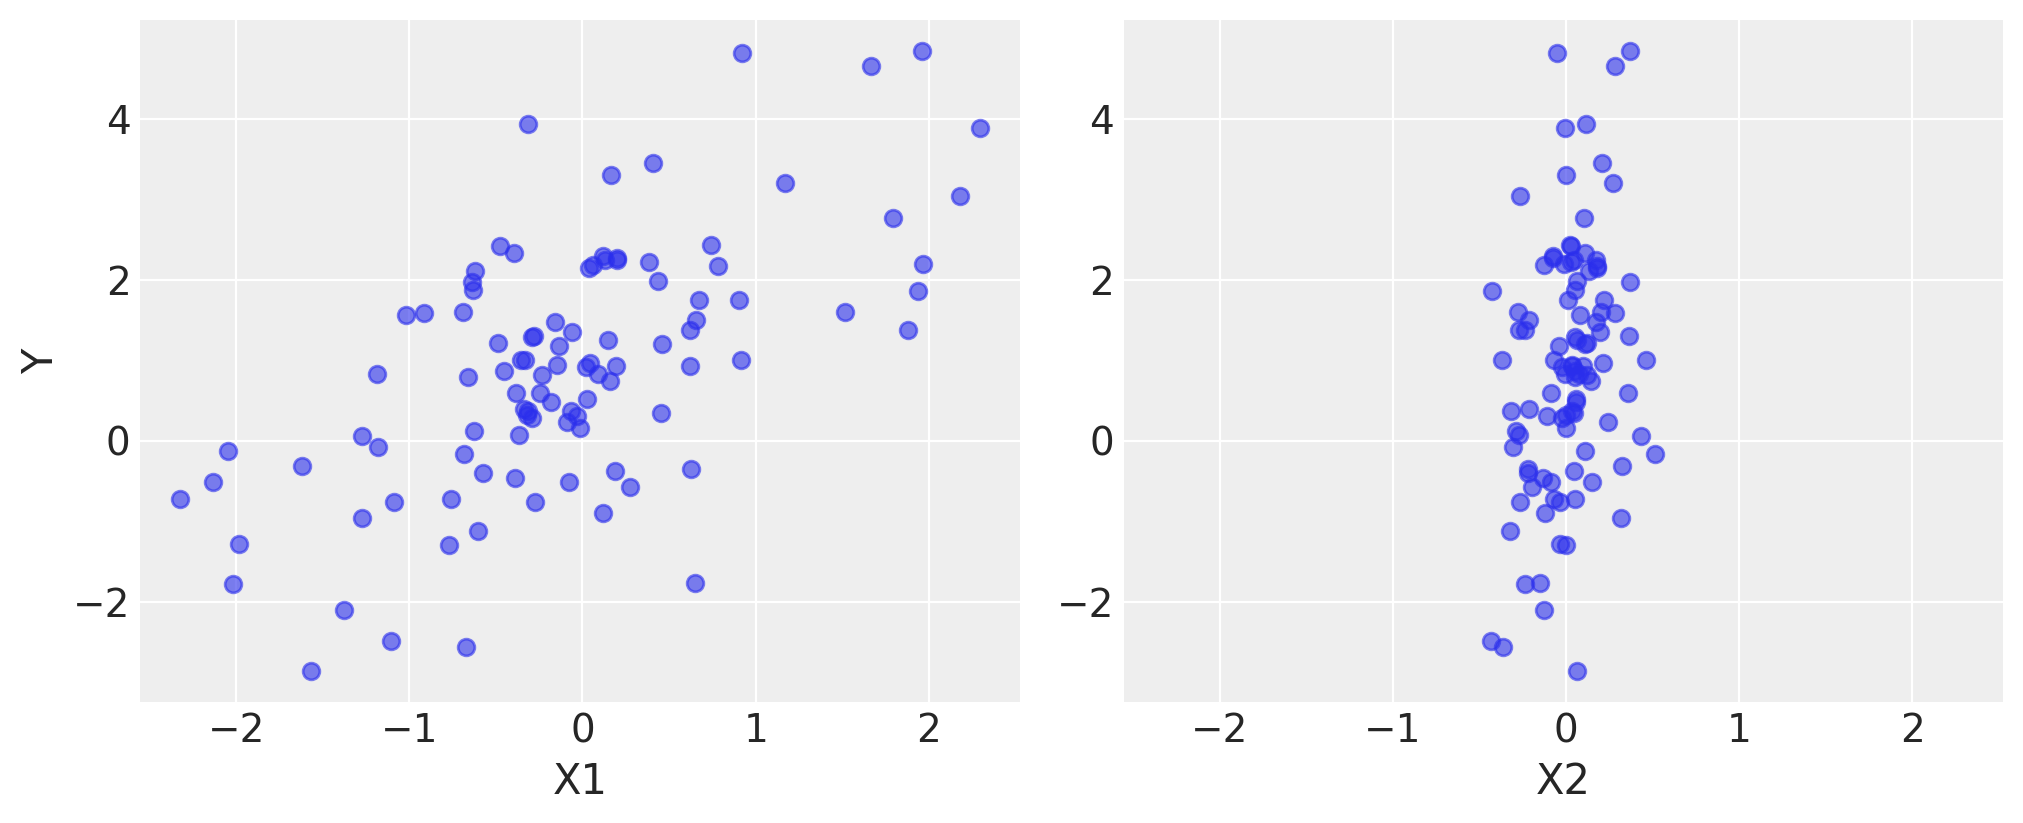

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

---

> **Pregunta:** ¿Que debemos hacer ahora,según el enfoque Bayesiano?



Debemos asignar distribuciones iniciales con el conocimiento *prior* que tengamos.

Asignemos:

- $\alpha \sim \mathcal{N}(0,10)$
- $\beta_i \sim \mathcal{N}(0,10)$
- $\sigma \sim |\mathcal{N}(0,1)$|


Nota: $|\mathcal{N}(0,1)|$ representa una *half-normal distribution*. Es decir, una distribución normal mayor que 0.


### Especificar el Modelo

Ahora que ya tenemos definidas nuestras variables aleatorias y sus distribuciones, debemos especificar el modelo en código.


PyMC3 funciona en base a Modelos.
Estas almacenan las variables a través de un *context manager* .

`with pm.Model() as nombre`


Recordemos: 


$$y \sim \mathcal{N}(\mu, \sigma^2 )$$

$$\mu = \alpha + \beta_1X_1  + \beta_2 X_2$$

con 

- $\alpha \sim \mathcal{N}(0,10)$
- $\beta_i \sim \mathcal{N}(0,10)$
- $\sigma \sim |\mathcal{N}(0,1)$|



In [ ]:
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [ ]:
with pm.Model() as basic_model:

    # 1. En este paso definimos los priors para cada variable aleatoria.
    # a cada variable aleatoria hay que asignarle un nombre y sus parámetros
    # según la distribución que estemos usando
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    # noten que en este caso tienen un parámetro shape=2
    # esto indica que habrán 2 parámetros beta.
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # 2. Estos son los valores esperados de los datos observados. 
    # noten que aquí estamos operando variables aleatorias :o
    # esta variable es llamada determinística ya que su valor está
    # completamente determinada por sus "padres" (las var. anteriores)
    mu = alpha + beta[0] * X1 + beta[1] * X2
    # en general, puede efectuarse cualquier operación con las variables
    # aleatorias en pymc3

    # 3. Definimos la distribución de las muestras para nuetro modelo 
    # noten que nuevamente dependen de las variables que definimos 
    # anteriormente. 
    # Pero además incluye el parámetro observed. En esta le pasamos los datos 
    # que usaremos para entrenar el modelo.
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

## Entrenamiento del Modelo

El siguiente paso es entrenar el modelo para obtener los posteriores de las variables desconocidas del modelo.

Existen dos formas de resolver esto en `PYMC3`: 

1. Maximum a posteriori (`MAP`) a través de modelos de optimización

2. Métodos de muestreo basados en Markov Chain Monte Carlo (`MCMC`).



### Maximum a Posteriori

Métodos sencillos para encontrar los parámetros basados en optimización.

Puede caer en óptimos locales. Además mientras más jerárquico sea el modelo, peor serán los parámetros encontrados.

In [ ]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma': array(1.0360356),
 'sigma_log__': array(0.03540151)}

In [ ]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)


{'alpha': array(0.95835519),
 'beta': array([1.1017629 , 2.95394057]),
 'sigma': array(1.03705179),
 'sigma_log__': array(0.03638187)}

## Métodos Basados en Muestreo


![](https://upload.wikimedia.org/wikipedia/commons/5/5e/Metropolis_algorithm_convergence_example.png)



In [ ]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3 seconds.


In [ ]:
trace["alpha"][-5:]

array([0.9141341 , 0.76446562, 0.83423568, 1.07120942, 0.86319131])

In [ ]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.


### Análisis Posterior

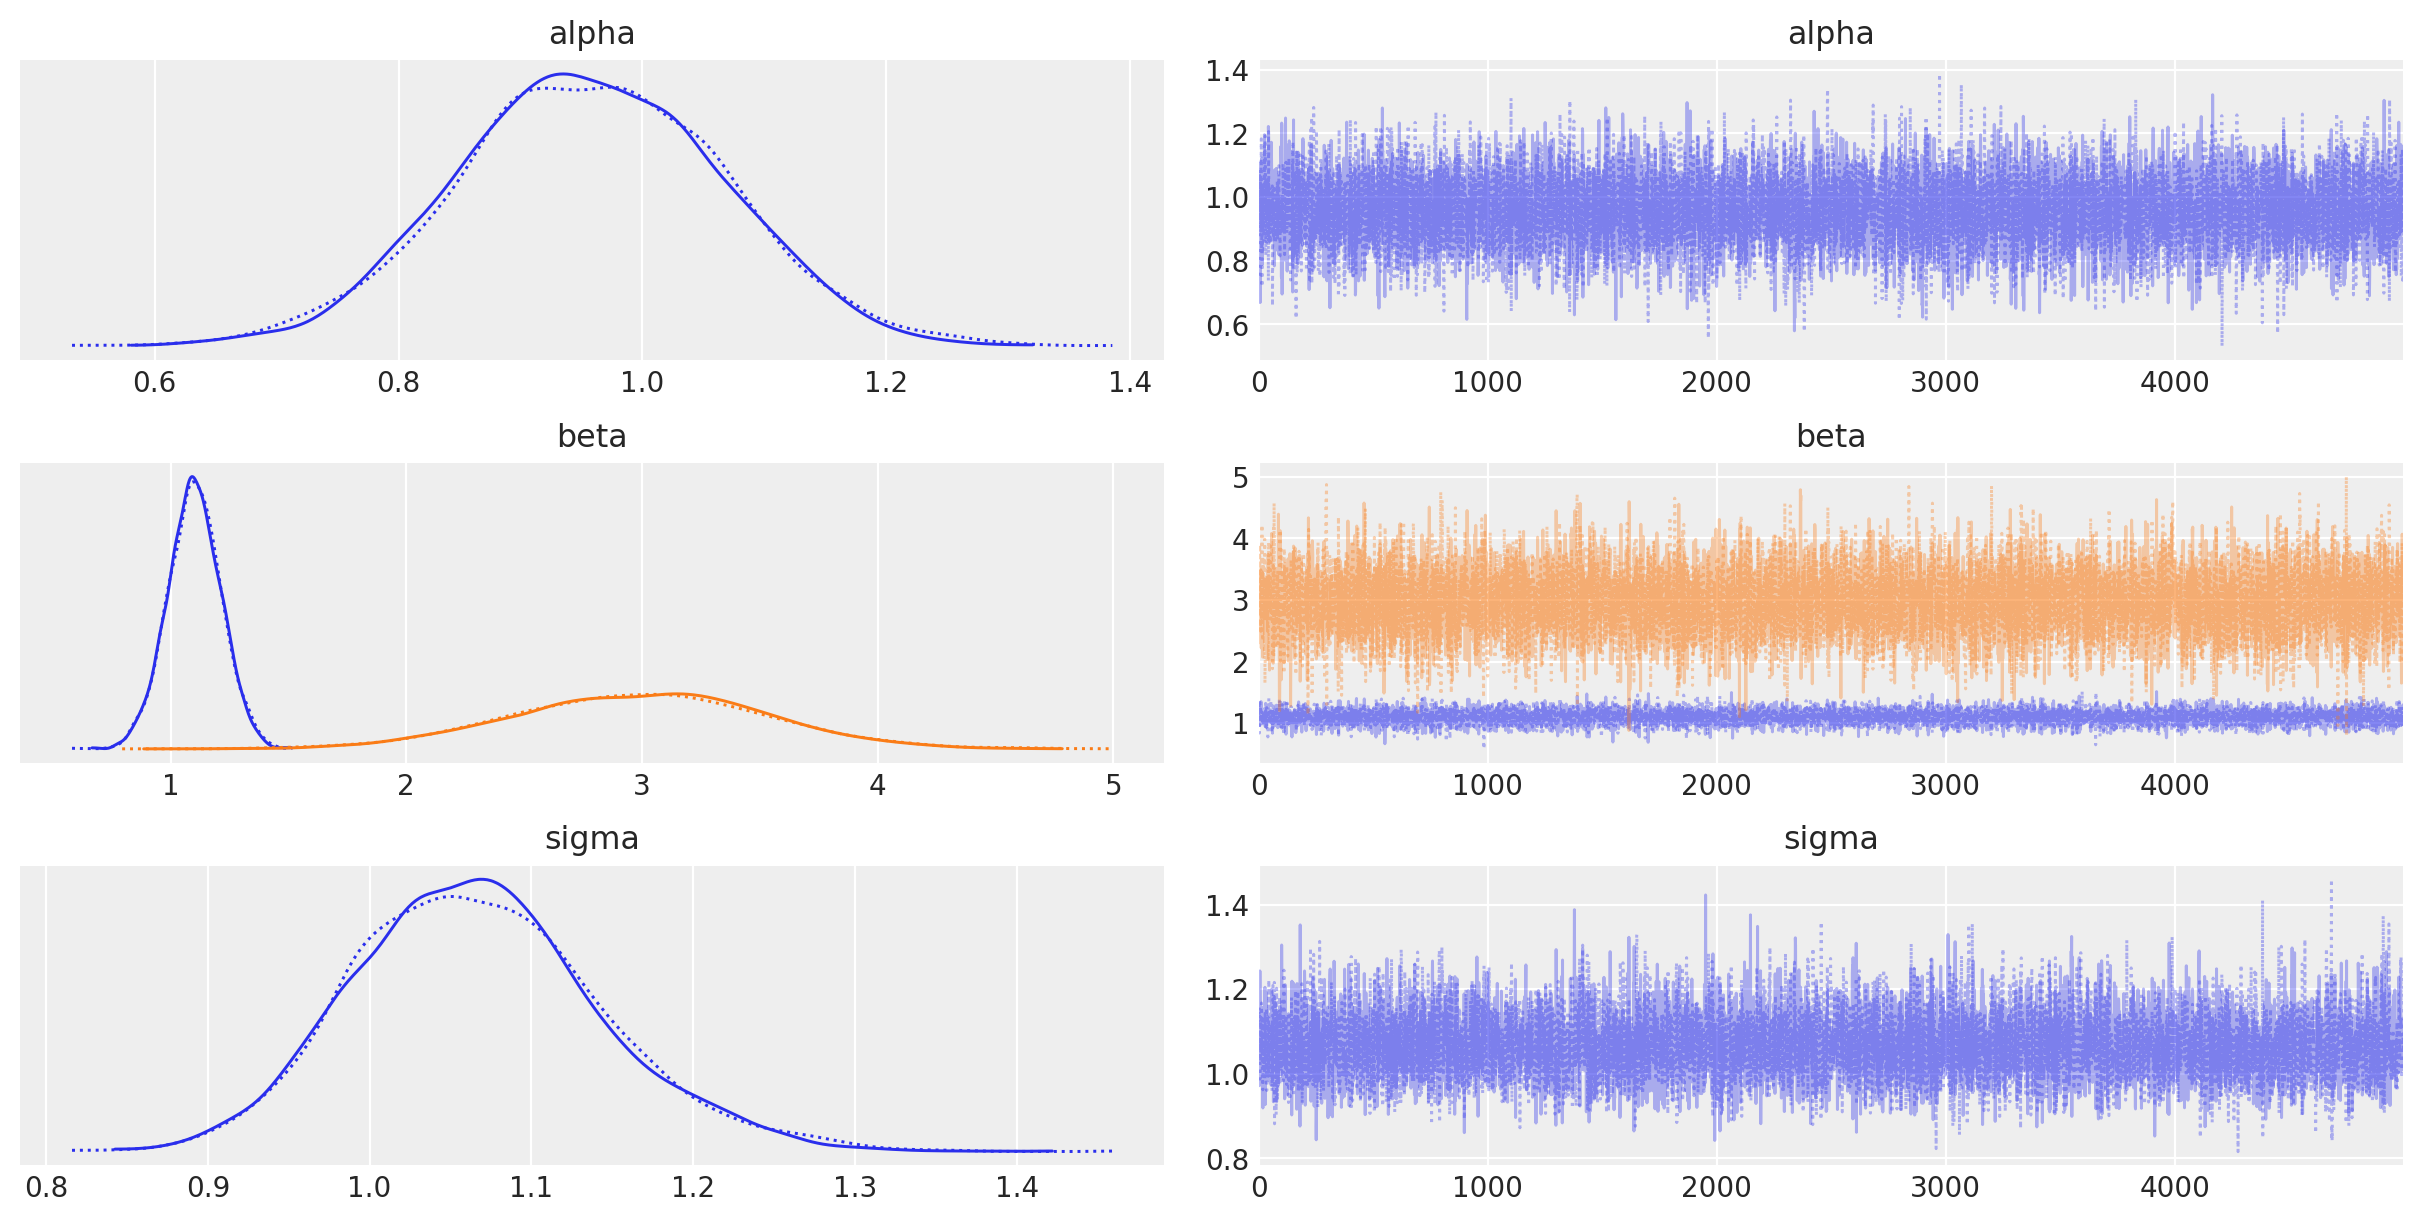

In [ ]:
with basic_model:
    az.plot_trace(trace);